In [1]:
import torch  
from tqdm.autonotebook import tqdm
from datasets_tools import load_dataset, create_splits
from datasets_tools import get_occupation_labels, load_embeddings
from model_utils import get_model

/var/folders/z7/zxmjm5fs0gg5rjdp2rjzm4kw0000gn/T/ipykernel_96236/929152306.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
baseline = 'normal' 
#baseline = 'nogender'

#modeltype, nb_epochs = 'RoBERTa', 10
#modeltype, nb_epochs = 'DeBERTa', 3
modeltype, nb_epochs = 'DistilBERT', 3


datafolder = "/Users/fannyjourdan/Documents/doctorat/jupyterlab_OSIRIM/data"
if baseline == "normal":
  model_path = f"/Users/fannyjourdan/Documents/doctorat/jupyterlab_OSIRIM/models/BIOS_occupations_prediction/{modeltype}_occBIOS_{nb_epochs}epochs_g1"  # predict occ
elif baseline == 'nogender':
  model_path = f"/Users/fannyjourdan/Documents/doctorat/jupyterlab_OSIRIM/models/BIOS_occupations_prediction/{modeltype}_occBIOS_{nb_epochs}epochs_ng1"  # predict occ

else:
  print("Baseline not found")

In [3]:
model_path

'/Users/fannyjourdan/Documents/doctorat/jupyterlab_OSIRIM/models/BIOS_occupations_prediction/DistilBERT_occBIOS_3epochs_g1'

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dt_X, gender_names, occ_names = load_dataset(datafolder, baseline=baseline)
splits, genders = create_splits(dt_X)
model, tokenizer = get_model(model_path, model_type = modeltype)
dt_X_train, dt_X_val, dt_X_test = splits
gender_train, gender_val, gender_test = genders

In [ ]:
dt_X

In [13]:
from utils import batch_predict

ntest = 50
features_ntest, labels_ntest = batch_predict(model.features, tokenizer, dt_X_test[:ntest], 32, device)
ypred_bis_ntest = model.end_model(features_ntest)
#print(type(ypred_bis_ntest))
#print(ypred_bis_ntest.shape)

ypred_ntest, labels_ntest = batch_predict(model.forward, tokenizer, dt_X_test[:ntest], 32, device)
#print(type(ypred_ntest))
#print(ypred_ntest.shape)

print("accuracy for classic model:", torch.mean((torch.argmax(ypred_ntest, -1) == labels_ntest).float()))
print("accuracy for model in 'two parts':", torch.mean((torch.argmax(ypred_bis_ntest, -1) == labels_ntest).float()))

100%|██████████| 2/2 [00:21<00:00, 10.67s/it]


<class 'torch.Tensor'>
torch.Size([50, 28])


100%|██████████| 2/2 [00:20<00:00, 10.03s/it]

<class 'torch.Tensor'>
torch.Size([50, 28])
accuracy for classic model: tensor(0.8600)
accuracy for model in 'two parts': tensor(0.8600)


In [5]:
datasets = dt_X_train, dt_X_val, dt_X_test
train_val_test_features, train_val_test_labels = load_embeddings(datasets,
                                                                 model=model,
                                                                 tokenizer=tokenizer,
                                                                 baseline=baseline,
                                                                 regenerate=False,
                                                                 model_type=modeltype,
                                                                 device=device)
train_features, val_features, test_features = train_val_test_features
train_labels, val_labels, test_labels = train_val_test_labels


train_labels, val_labels, test_labels = get_occupation_labels(dt_X_train, dt_X_val, dt_X_test, device)

In [8]:
test_features.shape

torch.Size([77773, 768])

In [9]:
ypred_test = model.end_model(test_features)
print("accuracy for classic model:", torch.mean((torch.argmax(ypred_test, -1) == test_labels).float()))

accuracy for classic model: tensor(0.8616)


In [10]:
train_features, train_features.shape

(tensor([[ 0.2168, -0.1917, -0.0909,  ..., -0.1493,  0.6019, -0.3022],
         [ 0.2391, -1.2215, -0.1873,  ..., -0.3146, -1.0283,  0.1730],
         [-0.0993, -1.4822, -0.8815,  ..., -0.1473,  0.4659,  0.4464],
         ...,
         [-0.2107, -0.4935, -0.4214,  ...,  0.1682, -0.5316, -0.5944],
         [-0.1397, -0.8739, -0.5273,  ...,  0.3629, -0.4720, -0.5824],
         [ 0.4278, -0.7748,  0.6118,  ...,  0.5999, -0.1254, -0.3630]]),
 torch.Size([77773, 768]))

In [11]:
val_features.shape, test_features.shape

(torch.Size([38886, 768]), torch.Size([77773, 768]))

In [12]:
train_labels.shape, val_labels.shape, test_labels.shape

(torch.Size([272203]), torch.Size([38886]), torch.Size([77773]))

In [13]:
gender_train.shape, gender_val.shape, gender_test.shape

((272203,), (38886,), (77773,))

# Train Model to predict gender

In [29]:
from train import train_genders
from train import LogisticMLP


retrain_gender_model = False
model_type = 'mlp'
real_dataset = (train_features, val_features, test_features)
save_name = f'gender_pred/{model_type}_baseline_{baseline}.pt'
if retrain_gender_model:
  pg_model = train_genders(real_dataset, genders,
                          batch_size=2048, test_batch_size=8192,
                          learning_rate=1e-3, epochs=200,
                          train_on_validation_set=True,
                          model_type=model_type,
                          save_path_and_name=save_name)
else:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  in_features = train_features.shape[1]
  state_dict = torch.load(save_name)
  pg_model = train_genders(real_dataset, genders,
                          batch_size=2048, test_batch_size=8192,
                          learning_rate=1e-3, epochs=0,
                          train_on_validation_set=True,
                          model_type=model_type,
                          state_dict=state_dict)

Final evaluation on the test set:

Val set: Average loss: 0.1151, Accuracy: 74672/77773 (96.013%)


Train to predict gender from occupation

Accuracy: 62.679%


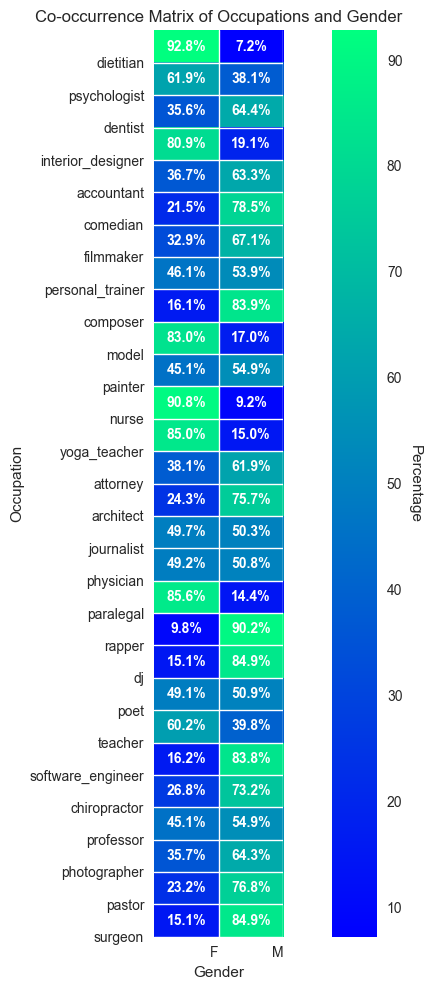

In [76]:
import numpy as np
from train import predict_gender_from_occupation

occupation_dataset = (train_labels, val_labels, test_labels)
predict_gender_from_occupation(occupation_dataset, genders)

# PART 1: Matrix decomposition

In [20]:
features = torch.cat((train_features, val_features, test_features), dim=0)

#refill the tensors:
n_train, n_val, n_test = len(train_features), len(val_features), len(test_features)
#train_features_new, val_features_new, test_features_new = features.split((n_train, n_val, n_test), dim=0)

In [21]:
from decomposition import decompose_choice

method_name = "sSVD"
num_components = 20
decomposition_method = decompose_choice(method_name, num_components)


U, W = decomposition_method.decompose(features)

num_components = U.shape[1]
print("num_components:", num_components)

num_components: 20


In [22]:
U.shape, W.shape

(torch.Size([388862, 20]), torch.Size([20, 768]))

In [23]:
U_train, U_val, U_test = U.split((n_train, n_val, n_test), dim=0)

# PART 2: Ranking concepts (Sobol)

In [17]:
from concept_removal import sobol_importance_from_sample

sobol_nb_design = 50
sampled = 10_000

pg_model.eval() 
global_importance_gender, rel_errors_all_masks = sobol_importance_from_sample(train_features, U_train.numpy(),
                                                                              W.numpy(), pg_model,
                                                                              sampled=sampled,
                                                                              num_components=num_components,
                                                                              sobol_nb_design=sobol_nb_design, 
                                                                              device=device)

100%|██████████| 10000/10000 [01:17<00:00, 128.82it/s]


In [18]:
import pickle
pickle.dump(global_importance_gender, open(f'global_importance/gi_gender_{method_name}{num_components}_{model_type}_baseline_{baseline}.pkl',"wb"))
pickle.dump(rel_errors_all_masks, open(f'global_importance/rel_error_gender_{method_name}{num_components}_{model_type}_baseline_{baseline}.pkl',"wb"))

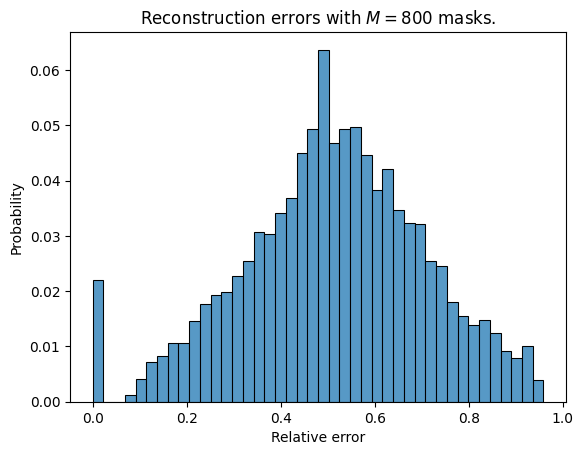

In [19]:
from visualization import plot_reconstruction_error
import matplotlib.pyplot as plt

plot_reconstruction_error(rel_errors_all_masks)

In [20]:
model.eval()
model_occ = lambda x: model.end_model(x)
global_importance_occ, _ = sobol_importance_from_sample(train_features, U_train.numpy(),
                                                        W.numpy(), model_occ,
                                                        sampled=sampled,
                                                        num_components=num_components,
                                                        sobol_nb_design=sobol_nb_design,
                                                        device=device)

100%|██████████| 10000/10000 [00:34<00:00, 288.99it/s]


In [21]:
pickle.dump(global_importance_occ, open(f'global_importance/gi_occupation_{method_name}{num_components}_{model_type}_baseline_{baseline}.pkl',"wb"))

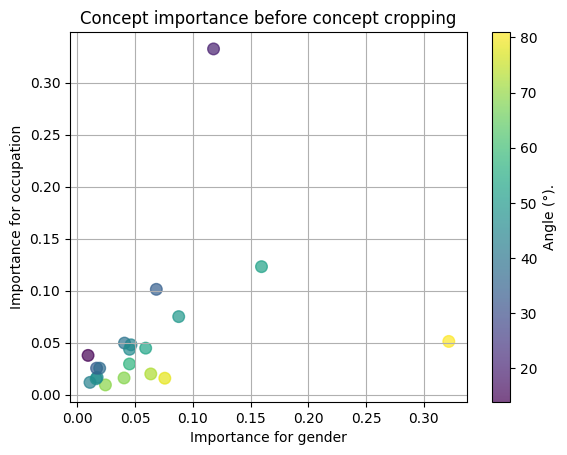

In [22]:
from visualization import plot_co_importance
plot_co_importance(global_importance_occ, global_importance_gender)

# PART 3: Remove concepts

In [23]:
import pickle
global_importance_gender = pickle.load(open(f'global_importance/gi_gender_{method_name}{num_components}_{model_type}_baseline_{baseline}.pkl',"rb"))
global_importance_occ = pickle.load(open(f'global_importance/gi_occupation_{method_name}{num_components}_{model_type}_baseline_{baseline}.pkl',"rb"))


In [24]:
import numpy as np

W_gender_max = np.argmax(global_importance_gender)
f"idx={W_gender_max} concepts={global_importance_gender}"

'idx=15 concepts=[0.0243585  0.07578097 0.01098823 0.01720361 0.04049529 0.01631085\n 0.01669117 0.06363044 0.00933065 0.01939207 0.04085953 0.04520055\n 0.05922386 0.04650775 0.04528637 0.32166594 0.08780622 0.06843268\n 0.15949547 0.11797746]'

In [25]:
W_occ_max = np.argmax(global_importance_occ)
f"idx={W_occ_max} concepts={global_importance_occ}"

'idx=19 concepts=[0.00927795 0.01573761 0.01171252 0.01654688 0.01598535 0.01522195\n 0.02540553 0.01985011 0.03767457 0.02538735 0.04953621 0.02944961\n 0.0446679  0.04788776 0.0435529  0.05111797 0.07500111 0.10124696\n 0.12307485 0.33257133]'

In [97]:
from concept_removal import crop_concepts, build_gender_neutral_features
import pickle

nb_cpt_remov = 1
angle = np.arctan(global_importance_occ / global_importance_gender) * 180 / np.pi
W_no_gender, to_keep = crop_concepts(W.numpy(), angle, num_or_threshold=num_components-nb_cpt_remov)


train_a_no_gender = build_gender_neutral_features(U_train.numpy(), W_no_gender, to_keep)
val_a_no_gender = build_gender_neutral_features(U_val.numpy(), W_no_gender, to_keep)
test_a_no_gender = build_gender_neutral_features(U_test.numpy(), W_no_gender, to_keep)
train_a_no_gender.shape, val_a_no_gender.shape, test_a_no_gender.shape

((272203, 768), (38886, 768), (77773, 768))

# Training new model without gender information

In [26]:
retrain = True
save_name = f'no_gender/pred_g_{method_name}{num_components}_cr{nb_cpt_remov}_b_{baseline}.pt'
real_dataset = train_a_no_gender, val_a_no_gender, test_a_no_gender


def to_cuda_tensor(arr):
    return torch.Tensor(arr).type(torch.FloatTensor).to(device)
real_dataset = tuple(map(to_cuda_tensor, real_dataset))
if retrain:
  pg_no_gender_model = train_genders(real_dataset, genders,
                                     batch_size=2048, test_batch_size=8192,
                                     learning_rate=5e-4, epochs=100,
                                     train_on_validation_set=True,
                                     model_type='mlp',
                                     save_path_and_name=save_name)
else:
  state_dict = torch.load(save_name)
  pg_no_gender_model = train_genders(real_dataset, genders,
                                     batch_size=2048, test_batch_size=8192,
                                     learning_rate=5e-4, epochs=0,
                                     train_on_validation_set=True,
                                     model_type='mlp',
                                     state_dict=state_dict,
                                     save_path_and_name=save_name)

Epoch 1

Val set: Average loss: 0.7015, Accuracy: 35899/77773 (46.159%)


Train Epoch: 1	Accuracy: 64.023%	Loss: 0.615357: 100%|██████████| 152/152 [00:02<00:00, 65.71it/s]

Epoch 2



Val set: Average loss: 0.6188, Accuracy: 51128/77773 (65.740%)


Train Epoch: 2	Accuracy: 66.098%	Loss: 0.606028: 100%|██████████| 152/152 [00:01<00:00, 77.88it/s]

Epoch 3



Val set: Average loss: 0.6127, Accuracy: 51811/77773 (66.618%)


Train Epoch: 3	Accuracy: 66.576%	Loss: 0.601804: 100%|██████████| 152/152 [00:02<00:00, 75.76it/s]

Epoch 4



Val set: Average loss: 0.6095, Accuracy: 52064/77773 (66.944%)


Train Epoch: 4	Accuracy: 66.821%	Loss: 0.599123: 100%|██████████| 152/152 [00:01<00:00, 78.88it/s]

Epoch 5



Val set: Average loss: 0.6074, Accuracy: 52177/77773 (67.089%)


Train Epoch: 5	Accuracy: 66.959%	Loss: 0.596678: 100%|██████████| 152/152 [00:01<00:00, 79.08it/s]

Epoch 6



Val set: Average loss: 0.6058, Accuracy: 52254/77773 (67.188%)


Train Epoch: 6	Accuracy: 67.090%	Loss: 0.594696: 100%|██████████| 152/152 [00:01<00:00, 76.44it/s]

Epoch 7



Val set: Average loss: 0.6043, Accuracy: 52319/77773 (67.271%)


Train Epoch: 7	Accuracy: 67.204%	Loss: 0.592963: 100%|██████████| 152/152 [00:01<00:00, 76.93it/s]

Epoch 8



Val set: Average loss: 0.6031, Accuracy: 52403/77773 (67.379%)


Train Epoch: 8	Accuracy: 67.239%	Loss: 0.591797: 100%|██████████| 152/152 [00:01<00:00, 79.56it/s]

Epoch 9



Val set: Average loss: 0.6020, Accuracy: 52436/77773 (67.422%)


Train Epoch: 9	Accuracy: 67.277%	Loss: 0.590733: 100%|██████████| 152/152 [00:01<00:00, 78.52it/s]

Epoch 10



Val set: Average loss: 0.6011, Accuracy: 52495/77773 (67.498%)


Train Epoch: 10	Accuracy: 67.356%	Loss: 0.589475: 100%|██████████| 152/152 [00:01<00:00, 76.53it/s]

Epoch 11



Val set: Average loss: 0.6001, Accuracy: 52495/77773 (67.498%)


Train Epoch: 11	Accuracy: 67.399%	Loss: 0.588675: 100%|██████████| 152/152 [00:02<00:00, 75.87it/s]

Epoch 12



Val set: Average loss: 0.5993, Accuracy: 52520/77773 (67.530%)


Train Epoch: 12	Accuracy: 67.468%	Loss: 0.587871: 100%|██████████| 152/152 [00:01<00:00, 78.47it/s]

Epoch 13



Val set: Average loss: 0.5986, Accuracy: 52555/77773 (67.575%)


Train Epoch: 13	Accuracy: 67.546%	Loss: 0.587388: 100%|██████████| 152/152 [00:01<00:00, 79.07it/s]

Epoch 14



Val set: Average loss: 0.5980, Accuracy: 52578/77773 (67.604%)


Train Epoch: 14	Accuracy: 67.577%	Loss: 0.586348: 100%|██████████| 152/152 [00:01<00:00, 76.54it/s]

Epoch 15



Val set: Average loss: 0.5973, Accuracy: 52626/77773 (67.666%)


Train Epoch: 15	Accuracy: 67.619%	Loss: 0.585338: 100%|██████████| 152/152 [00:01<00:00, 79.61it/s]

Epoch 16



Val set: Average loss: 0.5966, Accuracy: 52657/77773 (67.706%)


Train Epoch: 16	Accuracy: 67.659%	Loss: 0.584818: 100%|██████████| 152/152 [00:01<00:00, 79.33it/s]

Epoch 17



Val set: Average loss: 0.5961, Accuracy: 52716/77773 (67.782%)


Train Epoch: 17	Accuracy: 67.706%	Loss: 0.584335: 100%|██████████| 152/152 [00:01<00:00, 78.03it/s]

Epoch 18



Val set: Average loss: 0.5956, Accuracy: 52752/77773 (67.828%)


Train Epoch: 18	Accuracy: 67.731%	Loss: 0.583675: 100%|██████████| 152/152 [00:01<00:00, 79.47it/s]

Epoch 19



Val set: Average loss: 0.5952, Accuracy: 52735/77773 (67.806%)


Train Epoch: 19	Accuracy: 67.768%	Loss: 0.584253: 100%|██████████| 152/152 [00:01<00:00, 78.71it/s]

Epoch 20



Val set: Average loss: 0.5953, Accuracy: 52721/77773 (67.788%)


Train Epoch: 20	Accuracy: 67.823%	Loss: 0.583309: 100%|██████████| 152/152 [00:01<00:00, 77.04it/s]

Epoch 21



Val set: Average loss: 0.5943, Accuracy: 52809/77773 (67.901%)


Train Epoch: 21	Accuracy: 67.857%	Loss: 0.583026: 100%|██████████| 152/152 [00:01<00:00, 76.95it/s]

Epoch 22



Val set: Average loss: 0.5938, Accuracy: 52802/77773 (67.892%)


Train Epoch: 22	Accuracy: 67.927%	Loss: 0.583031: 100%|██████████| 152/152 [00:01<00:00, 78.54it/s]

Epoch 23



Val set: Average loss: 0.5936, Accuracy: 52802/77773 (67.892%)


Train Epoch: 23	Accuracy: 67.973%	Loss: 0.582375: 100%|██████████| 152/152 [00:01<00:00, 79.78it/s]

Epoch 24



Val set: Average loss: 0.5932, Accuracy: 52788/77773 (67.874%)


Train Epoch: 24	Accuracy: 68.032%	Loss: 0.582116: 100%|██████████| 152/152 [00:01<00:00, 76.50it/s]

Epoch 25



Val set: Average loss: 0.5927, Accuracy: 52831/77773 (67.930%)


Train Epoch: 25	Accuracy: 68.064%	Loss: 0.582600: 100%|██████████| 152/152 [00:01<00:00, 78.54it/s]

Epoch 26



Val set: Average loss: 0.5927, Accuracy: 52875/77773 (67.986%)


Train Epoch: 26	Accuracy: 68.104%	Loss: 0.581885: 100%|██████████| 152/152 [00:01<00:00, 78.77it/s]

Epoch 27



Val set: Average loss: 0.5923, Accuracy: 52866/77773 (67.975%)


Train Epoch: 27	Accuracy: 68.128%	Loss: 0.580877: 100%|██████████| 152/152 [00:01<00:00, 79.38it/s]

Epoch 28



Val set: Average loss: 0.5918, Accuracy: 52915/77773 (68.038%)


Train Epoch: 28	Accuracy: 68.146%	Loss: 0.580854: 100%|██████████| 152/152 [00:01<00:00, 79.13it/s]

Epoch 29



Val set: Average loss: 0.5916, Accuracy: 52939/77773 (68.069%)


Train Epoch: 29	Accuracy: 68.168%	Loss: 0.580778: 100%|██████████| 152/152 [00:01<00:00, 79.58it/s]

Epoch 30



Val set: Average loss: 0.5914, Accuracy: 52926/77773 (68.052%)


Train Epoch: 30	Accuracy: 68.222%	Loss: 0.580452: 100%|██████████| 152/152 [00:01<00:00, 77.04it/s]

Epoch 31



Val set: Average loss: 0.5911, Accuracy: 52984/77773 (68.126%)


Train Epoch: 31	Accuracy: 68.260%	Loss: 0.580143: 100%|██████████| 152/152 [00:01<00:00, 77.63it/s]

Epoch 32



Val set: Average loss: 0.5906, Accuracy: 53009/77773 (68.159%)


Train Epoch: 32	Accuracy: 68.288%	Loss: 0.579651: 100%|██████████| 152/152 [00:01<00:00, 78.78it/s]

Epoch 33



Val set: Average loss: 0.5905, Accuracy: 53031/77773 (68.187%)


Train Epoch: 33	Accuracy: 68.325%	Loss: 0.579243: 100%|██████████| 152/152 [00:02<00:00, 56.28it/s]

Epoch 34



Val set: Average loss: 0.5902, Accuracy: 53031/77773 (68.187%)


Train Epoch: 34	Accuracy: 68.361%	Loss: 0.579685: 100%|██████████| 152/152 [00:02<00:00, 70.58it/s]

Epoch 35



Val set: Average loss: 0.5901, Accuracy: 53063/77773 (68.228%)


Train Epoch: 35	Accuracy: 68.385%	Loss: 0.579207: 100%|██████████| 152/152 [00:01<00:00, 78.84it/s]

Epoch 36



Val set: Average loss: 0.5897, Accuracy: 53087/77773 (68.259%)


Train Epoch: 36	Accuracy: 68.428%	Loss: 0.579674: 100%|██████████| 152/152 [00:01<00:00, 79.04it/s]


Epoch 37

Val set: Average loss: 0.5896, Accuracy: 53133/77773 (68.318%)


Train Epoch: 37	Accuracy: 68.453%	Loss: 0.578817: 100%|██████████| 152/152 [00:01<00:00, 78.03it/s]

Epoch 38



Val set: Average loss: 0.5891, Accuracy: 53129/77773 (68.313%)


Train Epoch: 38	Accuracy: 68.485%	Loss: 0.577901: 100%|██████████| 152/152 [00:01<00:00, 77.86it/s]

Epoch 39



Val set: Average loss: 0.5888, Accuracy: 53158/77773 (68.350%)


Train Epoch: 39	Accuracy: 68.524%	Loss: 0.578814: 100%|██████████| 152/152 [00:01<00:00, 77.92it/s]

Epoch 40



Val set: Average loss: 0.5886, Accuracy: 53173/77773 (68.369%)


Train Epoch: 40	Accuracy: 68.576%	Loss: 0.577365: 100%|██████████| 152/152 [00:01<00:00, 77.11it/s]

Epoch 41



Val set: Average loss: 0.5883, Accuracy: 53182/77773 (68.381%)


Train Epoch: 41	Accuracy: 68.586%	Loss: 0.578537: 100%|██████████| 152/152 [00:01<00:00, 76.41it/s]

Epoch 42



Val set: Average loss: 0.5879, Accuracy: 53199/77773 (68.403%)


Train Epoch: 42	Accuracy: 68.600%	Loss: 0.577190: 100%|██████████| 152/152 [00:01<00:00, 78.93it/s]

Epoch 43



Val set: Average loss: 0.5878, Accuracy: 53202/77773 (68.407%)


Train Epoch: 43	Accuracy: 68.613%	Loss: 0.576382: 100%|██████████| 152/152 [00:01<00:00, 78.14it/s]

Epoch 44



Val set: Average loss: 0.5874, Accuracy: 53229/77773 (68.441%)


Train Epoch: 44	Accuracy: 68.649%	Loss: 0.576136: 100%|██████████| 152/152 [00:02<00:00, 75.63it/s]

Epoch 45



Val set: Average loss: 0.5873, Accuracy: 53242/77773 (68.458%)


Train Epoch: 45	Accuracy: 68.704%	Loss: 0.576346: 100%|██████████| 152/152 [00:01<00:00, 78.17it/s]

Epoch 46



Val set: Average loss: 0.5871, Accuracy: 53225/77773 (68.436%)


Train Epoch: 46	Accuracy: 68.730%	Loss: 0.575489: 100%|██████████| 152/152 [00:01<00:00, 79.38it/s]

Epoch 47



Val set: Average loss: 0.5870, Accuracy: 53238/77773 (68.453%)


Train Epoch: 47	Accuracy: 68.752%	Loss: 0.575615: 100%|██████████| 152/152 [00:01<00:00, 78.48it/s]

Epoch 48



Val set: Average loss: 0.5868, Accuracy: 53255/77773 (68.475%)


Train Epoch: 48	Accuracy: 68.780%	Loss: 0.575200: 100%|██████████| 152/152 [00:01<00:00, 77.90it/s]

Epoch 49



Val set: Average loss: 0.5865, Accuracy: 53274/77773 (68.499%)


Train Epoch: 49	Accuracy: 68.799%	Loss: 0.575292: 100%|██████████| 152/152 [00:01<00:00, 79.53it/s]

Epoch 50



Val set: Average loss: 0.5862, Accuracy: 53292/77773 (68.522%)


Train Epoch: 50	Accuracy: 68.819%	Loss: 0.575625: 100%|██████████| 152/152 [00:01<00:00, 76.62it/s]

Epoch 51



Val set: Average loss: 0.5859, Accuracy: 53285/77773 (68.513%)


Train Epoch: 51	Accuracy: 68.839%	Loss: 0.575402: 100%|██████████| 152/152 [00:01<00:00, 76.09it/s]

Epoch 52



Val set: Average loss: 0.5861, Accuracy: 53320/77773 (68.558%)


Train Epoch: 52	Accuracy: 68.829%	Loss: 0.575232: 100%|██████████| 152/152 [00:01<00:00, 77.82it/s]

Epoch 53



Val set: Average loss: 0.5859, Accuracy: 53324/77773 (68.564%)


Train Epoch: 53	Accuracy: 68.840%	Loss: 0.574530: 100%|██████████| 152/152 [00:01<00:00, 78.08it/s]

Epoch 54



Val set: Average loss: 0.5856, Accuracy: 53320/77773 (68.558%)


Train Epoch: 54	Accuracy: 68.861%	Loss: 0.574818: 100%|██████████| 152/152 [00:01<00:00, 76.01it/s]

Epoch 55



Val set: Average loss: 0.5853, Accuracy: 53348/77773 (68.594%)


Train Epoch: 55	Accuracy: 68.862%	Loss: 0.574739: 100%|██████████| 152/152 [00:01<00:00, 78.32it/s]

Epoch 56



Val set: Average loss: 0.5852, Accuracy: 53361/77773 (68.611%)


Train Epoch: 56	Accuracy: 68.897%	Loss: 0.574205: 100%|██████████| 152/152 [00:01<00:00, 78.79it/s]

Epoch 57



Val set: Average loss: 0.5851, Accuracy: 53349/77773 (68.596%)


Train Epoch: 57	Accuracy: 68.901%	Loss: 0.574203: 100%|██████████| 152/152 [00:01<00:00, 78.41it/s]

Epoch 58



Val set: Average loss: 0.5849, Accuracy: 53358/77773 (68.607%)


Train Epoch: 58	Accuracy: 68.942%	Loss: 0.573508: 100%|██████████| 152/152 [00:01<00:00, 77.87it/s]

Epoch 59



Val set: Average loss: 0.5851, Accuracy: 53350/77773 (68.597%)


Train Epoch: 59	Accuracy: 68.963%	Loss: 0.573569: 100%|██████████| 152/152 [00:01<00:00, 77.46it/s]

Epoch 60



Val set: Average loss: 0.5848, Accuracy: 53349/77773 (68.596%)


Train Epoch: 60	Accuracy: 68.968%	Loss: 0.572866: 100%|██████████| 152/152 [00:01<00:00, 76.44it/s]

Epoch 61



Val set: Average loss: 0.5847, Accuracy: 53366/77773 (68.618%)


Train Epoch: 61	Accuracy: 68.989%	Loss: 0.572859: 100%|██████████| 152/152 [00:02<00:00, 75.28it/s]

Epoch 62



Val set: Average loss: 0.5845, Accuracy: 53363/77773 (68.614%)


Train Epoch: 62	Accuracy: 68.979%	Loss: 0.572895: 100%|██████████| 152/152 [00:01<00:00, 76.84it/s]

Epoch 63



Val set: Average loss: 0.5844, Accuracy: 53377/77773 (68.632%)


Train Epoch: 63	Accuracy: 69.002%	Loss: 0.572916: 100%|██████████| 152/152 [00:02<00:00, 72.67it/s]

Epoch 64



Val set: Average loss: 0.5843, Accuracy: 53400/77773 (68.661%)


Train Epoch: 64	Accuracy: 68.977%	Loss: 0.572428: 100%|██████████| 152/152 [00:02<00:00, 71.90it/s]

Epoch 65



Val set: Average loss: 0.5839, Accuracy: 53413/77773 (68.678%)


Train Epoch: 65	Accuracy: 69.010%	Loss: 0.571909: 100%|██████████| 152/152 [00:02<00:00, 72.70it/s]

Epoch 66



Val set: Average loss: 0.5839, Accuracy: 53425/77773 (68.694%)


Train Epoch: 66	Accuracy: 69.015%	Loss: 0.572010: 100%|██████████| 152/152 [00:02<00:00, 74.12it/s]

Epoch 67



Val set: Average loss: 0.5837, Accuracy: 53393/77773 (68.652%)


Train Epoch: 67	Accuracy: 69.019%	Loss: 0.571804: 100%|██████████| 152/152 [00:02<00:00, 75.51it/s]

Epoch 68



Val set: Average loss: 0.5836, Accuracy: 53432/77773 (68.703%)


Train Epoch: 68	Accuracy: 69.043%	Loss: 0.571497: 100%|██████████| 152/152 [00:02<00:00, 73.96it/s]

Epoch 69



Val set: Average loss: 0.5836, Accuracy: 53434/77773 (68.705%)


Train Epoch: 69	Accuracy: 69.044%	Loss: 0.571119: 100%|██████████| 152/152 [00:02<00:00, 75.61it/s]

Epoch 70



Val set: Average loss: 0.5836, Accuracy: 53426/77773 (68.695%)


Train Epoch: 70	Accuracy: 69.068%	Loss: 0.570929: 100%|██████████| 152/152 [00:02<00:00, 75.49it/s]

Epoch 71



Val set: Average loss: 0.5835, Accuracy: 53415/77773 (68.681%)


Train Epoch: 71	Accuracy: 69.088%	Loss: 0.570659: 100%|██████████| 152/152 [00:02<00:00, 75.04it/s]

Epoch 72



Val set: Average loss: 0.5833, Accuracy: 53440/77773 (68.713%)


Train Epoch: 72	Accuracy: 69.084%	Loss: 0.570509: 100%|██████████| 152/152 [00:01<00:00, 77.68it/s]

Epoch 73



Val set: Average loss: 0.5833, Accuracy: 53464/77773 (68.744%)


Train Epoch: 73	Accuracy: 69.120%	Loss: 0.570648: 100%|██████████| 152/152 [00:01<00:00, 78.31it/s]

Epoch 74



Val set: Average loss: 0.5831, Accuracy: 53502/77773 (68.793%)


Train Epoch: 74	Accuracy: 69.120%	Loss: 0.570634: 100%|██████████| 152/152 [00:01<00:00, 76.45it/s]


Epoch 75

Val set: Average loss: 0.5831, Accuracy: 53514/77773 (68.808%)


Train Epoch: 75	Accuracy: 69.130%	Loss: 0.570100: 100%|██████████| 152/152 [00:01<00:00, 78.00it/s]

Epoch 76



Val set: Average loss: 0.5829, Accuracy: 53514/77773 (68.808%)


Train Epoch: 76	Accuracy: 69.162%	Loss: 0.570106: 100%|██████████| 152/152 [00:01<00:00, 77.28it/s]

Epoch 77



Val set: Average loss: 0.5827, Accuracy: 53528/77773 (68.826%)


Train Epoch: 77	Accuracy: 69.174%	Loss: 0.569510: 100%|██████████| 152/152 [00:01<00:00, 78.17it/s]

Epoch 78



Val set: Average loss: 0.5825, Accuracy: 53553/77773 (68.858%)


Train Epoch: 78	Accuracy: 69.189%	Loss: 0.569675: 100%|██████████| 152/152 [00:01<00:00, 78.07it/s]

Epoch 79



Val set: Average loss: 0.5825, Accuracy: 53528/77773 (68.826%)


Train Epoch: 79	Accuracy: 69.186%	Loss: 0.569568: 100%|██████████| 152/152 [00:01<00:00, 77.96it/s]

Epoch 80



Val set: Average loss: 0.5823, Accuracy: 53549/77773 (68.853%)


Train Epoch: 80	Accuracy: 69.194%	Loss: 0.569452: 100%|██████████| 152/152 [00:02<00:00, 75.47it/s]

Epoch 81



Val set: Average loss: 0.5824, Accuracy: 53545/77773 (68.848%)


Train Epoch: 81	Accuracy: 69.231%	Loss: 0.573923:  84%|████████▍ | 128/152 [00:01<00:00, 73.82it/s]

In [ ]:
from train import train_occupations

retrain = True
save_path = f'no_gender/pred_occ_{method_name}{num_components}_cr{nb_cpt_remov}_b_{baseline}.pt'
real_dataset = train_a_no_gender, val_a_no_gender, test_a_no_gender
occupations = train_labels, val_labels, test_labels
if retrain:
  pocc_no_gender_model = train_occupations(real_dataset, occupations,
                                           batch_size=2048, val_batch_size=8192,
                                           learning_rate=5e-4, epochs=100,
                                           train_on_validation_set=False,
                                           model_type='mlp',
                                           save_path_and_name=save_path)
                                          
else:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  in_features = train_a_no_gender.shape[1]
  state_dict = torch.load(save_path)
  pocc_no_gender_model = train_occupations(real_dataset, occupations,
                                           batch_size=2048, val_batch_size=8192,
                                           learning_rate=5e-4, epochs=0,
                                           train_on_validation_set=False,
                                           model_type='mlp',
                                           state_dict=state_dict,
                                           save_path_and_name=None)
                                           

Epoch 1

Val set: Average loss: 3.3346, Accuracy: 4987/38886 (12.825%)


Train Epoch: 1	Accuracy: 65.860%	Loss: 0.987321: 100%|██████████| 133/133 [00:01<00:00, 69.49it/s]


Epoch 2

Val set: Average loss: 1.1283, Accuracy: 26225/38886 (67.441%)


Train Epoch: 2	Accuracy: 71.363%	Loss: 0.885971: 100%|██████████| 133/133 [00:01<00:00, 81.01it/s]


Epoch 3

Val set: Average loss: 1.0301, Accuracy: 27406/38886 (70.478%)


Train Epoch: 3	Accuracy: 74.797%	Loss: 0.811797: 100%|██████████| 133/133 [00:01<00:00, 83.29it/s]


Epoch 4

Val set: Average loss: 0.9553, Accuracy: 28864/38886 (74.227%)


Train Epoch: 4	Accuracy: 78.136%	Loss: 0.755364: 100%|██████████| 133/133 [00:01<00:00, 83.01it/s]


Epoch 5

Val set: Average loss: 0.8981, Accuracy: 29922/38886 (76.948%)


Train Epoch: 5	Accuracy: 80.049%	Loss: 0.714700: 100%|██████████| 133/133 [00:01<00:00, 81.25it/s]


Epoch 6

Val set: Average loss: 0.8582, Accuracy: 30397/38886 (78.170%)


Train Epoch: 6	Accuracy: 80.812%	Loss: 0.686875: 100%|██████████| 133/133 [00:01<00:00, 84.37it/s]


Epoch 7

Val set: Average loss: 0.8295, Accuracy: 30623/38886 (78.751%)


Train Epoch: 7	Accuracy: 81.317%	Loss: 0.667103: 100%|██████████| 133/133 [00:01<00:00, 83.56it/s]


Epoch 8

Val set: Average loss: 0.8080, Accuracy: 30802/38886 (79.211%)


Train Epoch: 8	Accuracy: 81.674%	Loss: 0.650600: 100%|██████████| 133/133 [00:01<00:00, 83.35it/s]


Epoch 9

Val set: Average loss: 0.7916, Accuracy: 30899/38886 (79.460%)


Train Epoch: 9	Accuracy: 81.974%	Loss: 0.638061: 100%|██████████| 133/133 [00:01<00:00, 84.40it/s]


Epoch 10

Val set: Average loss: 0.7789, Accuracy: 30975/38886 (79.656%)


Train Epoch: 10	Accuracy: 82.224%	Loss: 0.627033: 100%|██████████| 133/133 [00:01<00:00, 83.18it/s]


Epoch 11

Val set: Average loss: 0.7683, Accuracy: 31052/38886 (79.854%)


Train Epoch: 11	Accuracy: 82.432%	Loss: 0.617025: 100%|██████████| 133/133 [00:01<00:00, 84.32it/s]


Epoch 12

Val set: Average loss: 0.7597, Accuracy: 31138/38886 (80.075%)


Train Epoch: 12	Accuracy: 82.605%	Loss: 0.608662: 100%|██████████| 133/133 [00:01<00:00, 82.33it/s]


Epoch 13

Val set: Average loss: 0.7522, Accuracy: 31180/38886 (80.183%)


Train Epoch: 13	Accuracy: 82.798%	Loss: 0.601305: 100%|██████████| 133/133 [00:01<00:00, 83.37it/s]


Epoch 14

Val set: Average loss: 0.7464, Accuracy: 31250/38886 (80.363%)


Train Epoch: 14	Accuracy: 82.935%	Loss: 0.595106: 100%|██████████| 133/133 [00:01<00:00, 84.32it/s]


Epoch 15

Val set: Average loss: 0.7411, Accuracy: 31299/38886 (80.489%)


Train Epoch: 15	Accuracy: 83.064%	Loss: 0.590359: 100%|██████████| 133/133 [00:01<00:00, 83.56it/s]


Epoch 16

Val set: Average loss: 0.7363, Accuracy: 31350/38886 (80.620%)


Train Epoch: 16	Accuracy: 83.188%	Loss: 0.585786: 100%|██████████| 133/133 [00:01<00:00, 84.06it/s]


Epoch 17

Val set: Average loss: 0.7322, Accuracy: 31410/38886 (80.775%)


Train Epoch: 17	Accuracy: 83.311%	Loss: 0.581715: 100%|██████████| 133/133 [00:01<00:00, 83.21it/s]


Epoch 18

Val set: Average loss: 0.7286, Accuracy: 31448/38886 (80.872%)


Train Epoch: 18	Accuracy: 83.418%	Loss: 0.577665: 100%|██████████| 133/133 [00:01<00:00, 83.78it/s]


Epoch 19

Val set: Average loss: 0.7253, Accuracy: 31454/38886 (80.888%)


Train Epoch: 19	Accuracy: 83.494%	Loss: 0.574459: 100%|██████████| 133/133 [00:01<00:00, 83.91it/s]


Epoch 20

Val set: Average loss: 0.7224, Accuracy: 31498/38886 (81.001%)


Train Epoch: 20	Accuracy: 83.578%	Loss: 0.571677: 100%|██████████| 133/133 [00:01<00:00, 82.70it/s]


Epoch 21

Val set: Average loss: 0.7196, Accuracy: 31528/38886 (81.078%)


Train Epoch: 21	Accuracy: 83.656%	Loss: 0.569231: 100%|██████████| 133/133 [00:01<00:00, 84.23it/s]


Epoch 22

Val set: Average loss: 0.7173, Accuracy: 31563/38886 (81.168%)


Train Epoch: 22	Accuracy: 83.722%	Loss: 0.566855: 100%|██████████| 133/133 [00:01<00:00, 84.47it/s]


Epoch 23

Val set: Average loss: 0.7149, Accuracy: 31586/38886 (81.227%)


Train Epoch: 23	Accuracy: 83.774%	Loss: 0.564522: 100%|██████████| 133/133 [00:01<00:00, 83.39it/s]


Epoch 24

Val set: Average loss: 0.7129, Accuracy: 31601/38886 (81.266%)


Train Epoch: 24	Accuracy: 83.822%	Loss: 0.562660: 100%|██████████| 133/133 [00:01<00:00, 83.85it/s]


Epoch 25

Val set: Average loss: 0.7109, Accuracy: 31609/38886 (81.286%)


Train Epoch: 25	Accuracy: 83.860%	Loss: 0.560829: 100%|██████████| 133/133 [00:01<00:00, 82.81it/s]


Epoch 26

Val set: Average loss: 0.7090, Accuracy: 31618/38886 (81.309%)


Train Epoch: 26	Accuracy: 83.909%	Loss: 0.559233: 100%|██████████| 133/133 [00:01<00:00, 83.17it/s]


Epoch 27

Val set: Average loss: 0.7074, Accuracy: 31648/38886 (81.387%)


Train Epoch: 27	Accuracy: 83.965%	Loss: 0.557791: 100%|██████████| 133/133 [00:01<00:00, 84.42it/s]


Epoch 28

Val set: Average loss: 0.7059, Accuracy: 31648/38886 (81.387%)


Train Epoch: 28	Accuracy: 84.013%	Loss: 0.557006: 100%|██████████| 133/133 [00:01<00:00, 83.08it/s]


Epoch 29

Val set: Average loss: 0.7043, Accuracy: 31674/38886 (81.453%)


Train Epoch: 29	Accuracy: 84.063%	Loss: 0.556272: 100%|██████████| 133/133 [00:01<00:00, 84.37it/s]


Epoch 30

Val set: Average loss: 0.7029, Accuracy: 31679/38886 (81.466%)


Train Epoch: 30	Accuracy: 84.106%	Loss: 0.554985: 100%|██████████| 133/133 [00:01<00:00, 83.60it/s]


Epoch 31

Val set: Average loss: 0.7015, Accuracy: 31710/38886 (81.546%)


Train Epoch: 31	Accuracy: 84.135%	Loss: 0.554139: 100%|██████████| 133/133 [00:01<00:00, 83.73it/s]


Epoch 32

Val set: Average loss: 0.7000, Accuracy: 31725/38886 (81.585%)


Train Epoch: 32	Accuracy: 84.171%	Loss: 0.553304: 100%|██████████| 133/133 [00:01<00:00, 84.96it/s]


Epoch 33

Val set: Average loss: 0.6988, Accuracy: 31721/38886 (81.574%)


Train Epoch: 33	Accuracy: 84.205%	Loss: 0.552713: 100%|██████████| 133/133 [00:01<00:00, 83.48it/s]


Epoch 34

Val set: Average loss: 0.6975, Accuracy: 31747/38886 (81.641%)


Train Epoch: 34	Accuracy: 84.243%	Loss: 0.551563: 100%|██████████| 133/133 [00:01<00:00, 84.19it/s]


Epoch 35

Val set: Average loss: 0.6964, Accuracy: 31746/38886 (81.639%)


Train Epoch: 35	Accuracy: 84.279%	Loss: 0.550602: 100%|██████████| 133/133 [00:01<00:00, 84.16it/s]


Epoch 36

Val set: Average loss: 0.6954, Accuracy: 31744/38886 (81.633%)


Train Epoch: 36	Accuracy: 84.302%	Loss: 0.549323: 100%|██████████| 133/133 [00:01<00:00, 83.89it/s]


Epoch 37

Val set: Average loss: 0.6943, Accuracy: 31762/38886 (81.680%)


Train Epoch: 37	Accuracy: 84.333%	Loss: 0.548267: 100%|██████████| 133/133 [00:01<00:00, 84.15it/s]


Epoch 38

Val set: Average loss: 0.6933, Accuracy: 31769/38886 (81.698%)


Train Epoch: 38	Accuracy: 84.364%	Loss: 0.547337: 100%|██████████| 133/133 [00:01<00:00, 84.03it/s]


Epoch 39

Val set: Average loss: 0.6923, Accuracy: 31761/38886 (81.677%)


Train Epoch: 39	Accuracy: 84.392%	Loss: 0.546153: 100%|██████████| 133/133 [00:01<00:00, 83.82it/s]


Epoch 40

Val set: Average loss: 0.6914, Accuracy: 31773/38886 (81.708%)


Train Epoch: 40	Accuracy: 84.406%	Loss: 0.545178: 100%|██████████| 133/133 [00:01<00:00, 84.11it/s]


Epoch 41

Val set: Average loss: 0.6906, Accuracy: 31780/38886 (81.726%)


Train Epoch: 41	Accuracy: 84.424%	Loss: 0.544939: 100%|██████████| 133/133 [00:01<00:00, 83.27it/s]


Epoch 42

Val set: Average loss: 0.6897, Accuracy: 31791/38886 (81.754%)


Train Epoch: 42	Accuracy: 84.452%	Loss: 0.544038: 100%|██████████| 133/133 [00:01<00:00, 83.89it/s]


Epoch 43

Val set: Average loss: 0.6889, Accuracy: 31803/38886 (81.785%)


Train Epoch: 43	Accuracy: 84.484%	Loss: 0.543393: 100%|██████████| 133/133 [00:01<00:00, 83.12it/s]


Epoch 44

Val set: Average loss: 0.6881, Accuracy: 31809/38886 (81.801%)


Train Epoch: 44	Accuracy: 84.507%	Loss: 0.542204: 100%|██████████| 133/133 [00:01<00:00, 82.92it/s]


Epoch 45

Val set: Average loss: 0.6875, Accuracy: 31814/38886 (81.814%)


Train Epoch: 45	Accuracy: 84.516%	Loss: 0.541472: 100%|██████████| 133/133 [00:01<00:00, 83.71it/s]


Epoch 46

Val set: Average loss: 0.6867, Accuracy: 31820/38886 (81.829%)


Train Epoch: 46	Accuracy: 84.541%	Loss: 0.540936: 100%|██████████| 133/133 [00:01<00:00, 83.29it/s]


Epoch 47

Val set: Average loss: 0.6862, Accuracy: 31838/38886 (81.875%)


Train Epoch: 47	Accuracy: 84.555%	Loss: 0.540511: 100%|██████████| 133/133 [00:01<00:00, 84.33it/s]


Epoch 48

Val set: Average loss: 0.6856, Accuracy: 31843/38886 (81.888%)


Train Epoch: 48	Accuracy: 84.572%	Loss: 0.539564: 100%|██████████| 133/133 [00:01<00:00, 83.42it/s]


Epoch 49

Val set: Average loss: 0.6848, Accuracy: 31854/38886 (81.916%)


Train Epoch: 49	Accuracy: 84.599%	Loss: 0.538838: 100%|██████████| 133/133 [00:01<00:00, 83.67it/s]


Epoch 50

Val set: Average loss: 0.6841, Accuracy: 31870/38886 (81.958%)


Train Epoch: 50	Accuracy: 84.627%	Loss: 0.537830: 100%|██████████| 133/133 [00:01<00:00, 84.07it/s]


Epoch 51

Val set: Average loss: 0.6834, Accuracy: 31867/38886 (81.950%)


Train Epoch: 51	Accuracy: 84.645%	Loss: 0.537237: 100%|██████████| 133/133 [00:01<00:00, 82.87it/s]


Epoch 52

Val set: Average loss: 0.6828, Accuracy: 31883/38886 (81.991%)


Train Epoch: 52	Accuracy: 84.665%	Loss: 0.536795: 100%|██████████| 133/133 [00:01<00:00, 83.56it/s]


Epoch 53

Val set: Average loss: 0.6822, Accuracy: 31885/38886 (81.996%)


Train Epoch: 53	Accuracy: 84.672%	Loss: 0.535989: 100%|██████████| 133/133 [00:01<00:00, 83.58it/s]


Epoch 54

Val set: Average loss: 0.6817, Accuracy: 31889/38886 (82.006%)


Train Epoch: 54	Accuracy: 84.701%	Loss: 0.535213: 100%|██████████| 133/133 [00:01<00:00, 83.40it/s]


Epoch 55

Val set: Average loss: 0.6811, Accuracy: 31899/38886 (82.032%)


Train Epoch: 55	Accuracy: 84.715%	Loss: 0.534441: 100%|██████████| 133/133 [00:01<00:00, 84.00it/s]


Epoch 56

Val set: Average loss: 0.6806, Accuracy: 31902/38886 (82.040%)


Train Epoch: 56	Accuracy: 84.723%	Loss: 0.533898: 100%|██████████| 133/133 [00:01<00:00, 83.83it/s]


Epoch 57

Val set: Average loss: 0.6801, Accuracy: 31904/38886 (82.045%)


Train Epoch: 57	Accuracy: 84.733%	Loss: 0.533300: 100%|██████████| 133/133 [00:01<00:00, 82.87it/s]


Epoch 58

Val set: Average loss: 0.6795, Accuracy: 31918/38886 (82.081%)


Train Epoch: 58	Accuracy: 84.750%	Loss: 0.532883: 100%|██████████| 133/133 [00:01<00:00, 83.23it/s]


Epoch 59

Val set: Average loss: 0.6790, Accuracy: 31914/38886 (82.071%)


Train Epoch: 59	Accuracy: 84.764%	Loss: 0.532299: 100%|██████████| 133/133 [00:01<00:00, 83.03it/s]


Epoch 60

Val set: Average loss: 0.6785, Accuracy: 31914/38886 (82.071%)


Train Epoch: 60	Accuracy: 84.767%	Loss: 0.531856: 100%|██████████| 133/133 [00:01<00:00, 82.75it/s]


Epoch 61

Val set: Average loss: 0.6781, Accuracy: 31923/38886 (82.094%)


Train Epoch: 61	Accuracy: 84.769%	Loss: 0.531301: 100%|██████████| 133/133 [00:01<00:00, 83.42it/s]


Epoch 62

Val set: Average loss: 0.6777, Accuracy: 31917/38886 (82.078%)


Train Epoch: 62	Accuracy: 84.790%	Loss: 0.530854: 100%|██████████| 133/133 [00:01<00:00, 83.20it/s]


Epoch 63

Val set: Average loss: 0.6773, Accuracy: 31911/38886 (82.063%)


Train Epoch: 63	Accuracy: 84.805%	Loss: 0.530431: 100%|██████████| 133/133 [00:01<00:00, 83.84it/s]


Epoch 64

Val set: Average loss: 0.6769, Accuracy: 31916/38886 (82.076%)


Train Epoch: 64	Accuracy: 84.817%	Loss: 0.530034: 100%|██████████| 133/133 [00:01<00:00, 83.35it/s]


Epoch 65

Val set: Average loss: 0.6765, Accuracy: 31920/38886 (82.086%)


Train Epoch: 65	Accuracy: 84.822%	Loss: 0.529769: 100%|██████████| 133/133 [00:01<00:00, 82.64it/s]


Epoch 66

Val set: Average loss: 0.6760, Accuracy: 31916/38886 (82.076%)


Train Epoch: 66	Accuracy: 84.828%	Loss: 0.529385: 100%|██████████| 133/133 [00:01<00:00, 83.83it/s]


Epoch 67

Val set: Average loss: 0.6757, Accuracy: 31920/38886 (82.086%)


Train Epoch: 67	Accuracy: 84.856%	Loss: 0.528941: 100%|██████████| 133/133 [00:01<00:00, 82.53it/s]


Epoch 68

Val set: Average loss: 0.6755, Accuracy: 31924/38886 (82.096%)


Train Epoch: 68	Accuracy: 84.864%	Loss: 0.528353: 100%|██████████| 133/133 [00:01<00:00, 82.59it/s]


Epoch 69

Val set: Average loss: 0.6752, Accuracy: 31920/38886 (82.086%)


Train Epoch: 69	Accuracy: 84.862%	Loss: 0.527930: 100%|██████████| 133/133 [00:01<00:00, 82.73it/s]


Epoch 70

Val set: Average loss: 0.6748, Accuracy: 31931/38886 (82.114%)


Train Epoch: 70	Accuracy: 84.865%	Loss: 0.527025: 100%|██████████| 133/133 [00:01<00:00, 82.57it/s]


Epoch 71

Val set: Average loss: 0.6745, Accuracy: 31929/38886 (82.109%)


Train Epoch: 71	Accuracy: 84.872%	Loss: 0.526659: 100%|██████████| 133/133 [00:01<00:00, 83.33it/s]


Epoch 72

Val set: Average loss: 0.6742, Accuracy: 31930/38886 (82.112%)


Train Epoch: 72	Accuracy: 84.867%	Loss: 0.526318: 100%|██████████| 133/133 [00:01<00:00, 82.56it/s]


Epoch 73

Val set: Average loss: 0.6738, Accuracy: 31927/38886 (82.104%)


Train Epoch: 73	Accuracy: 84.877%	Loss: 0.525636: 100%|██████████| 133/133 [00:01<00:00, 82.67it/s]


Epoch 74

Val set: Average loss: 0.6735, Accuracy: 31927/38886 (82.104%)


Train Epoch: 74	Accuracy: 84.905%	Loss: 0.525065: 100%|██████████| 133/133 [00:01<00:00, 83.95it/s]


Epoch 75

Val set: Average loss: 0.6732, Accuracy: 31928/38886 (82.107%)


Train Epoch: 75	Accuracy: 84.896%	Loss: 0.524865: 100%|██████████| 133/133 [00:01<00:00, 82.49it/s]


Epoch 76

Val set: Average loss: 0.6728, Accuracy: 31932/38886 (82.117%)


Train Epoch: 76	Accuracy: 84.908%	Loss: 0.524600: 100%|██████████| 133/133 [00:01<00:00, 83.54it/s]


Epoch 77

Val set: Average loss: 0.6726, Accuracy: 31935/38886 (82.125%)


Train Epoch: 77	Accuracy: 84.914%	Loss: 0.524276: 100%|██████████| 133/133 [00:01<00:00, 83.88it/s]


Epoch 78

Val set: Average loss: 0.6722, Accuracy: 31931/38886 (82.114%)


Train Epoch: 78	Accuracy: 84.926%	Loss: 0.524075: 100%|██████████| 133/133 [00:01<00:00, 82.76it/s]


Epoch 79

Val set: Average loss: 0.6719, Accuracy: 31937/38886 (82.130%)


Train Epoch: 79	Accuracy: 84.920%	Loss: 0.524069: 100%|██████████| 133/133 [00:01<00:00, 83.32it/s]


Epoch 80

Val set: Average loss: 0.6715, Accuracy: 31940/38886 (82.138%)


Train Epoch: 80	Accuracy: 84.927%	Loss: 0.524223: 100%|██████████| 133/133 [00:01<00:00, 82.55it/s]


Epoch 81

Val set: Average loss: 0.6712, Accuracy: 31948/38886 (82.158%)


Train Epoch: 81	Accuracy: 84.939%	Loss: 0.523819: 100%|██████████| 133/133 [00:01<00:00, 82.24it/s]


Epoch 82

Val set: Average loss: 0.6709, Accuracy: 31955/38886 (82.176%)


Train Epoch: 82	Accuracy: 84.956%	Loss: 0.523568: 100%|██████████| 133/133 [00:01<00:00, 82.49it/s]


Epoch 83

Val set: Average loss: 0.6706, Accuracy: 31950/38886 (82.163%)


Train Epoch: 83	Accuracy: 84.960%	Loss: 0.523326: 100%|██████████| 133/133 [00:01<00:00, 82.91it/s]


Epoch 84

Val set: Average loss: 0.6704, Accuracy: 31942/38886 (82.143%)


Train Epoch: 84	Accuracy: 84.973%	Loss: 0.522888: 100%|██████████| 133/133 [00:01<00:00, 83.72it/s]


Epoch 85

Val set: Average loss: 0.6702, Accuracy: 31948/38886 (82.158%)


Train Epoch: 85	Accuracy: 84.976%	Loss: 0.522777: 100%|██████████| 133/133 [00:01<00:00, 82.79it/s]


Epoch 86

Val set: Average loss: 0.6699, Accuracy: 31955/38886 (82.176%)


Train Epoch: 86	Accuracy: 84.987%	Loss: 0.522631: 100%|██████████| 133/133 [00:01<00:00, 83.00it/s]


Epoch 87

Val set: Average loss: 0.6698, Accuracy: 31955/38886 (82.176%)


Train Epoch: 87	Accuracy: 84.990%	Loss: 0.522403: 100%|██████████| 133/133 [00:01<00:00, 83.03it/s]


Epoch 88

Val set: Average loss: 0.6695, Accuracy: 31967/38886 (82.207%)


Train Epoch: 88	Accuracy: 84.999%	Loss: 0.522191: 100%|██████████| 133/133 [00:01<00:00, 83.17it/s]


Epoch 89

Val set: Average loss: 0.6692, Accuracy: 31976/38886 (82.230%)


Train Epoch: 89	Accuracy: 85.014%	Loss: 0.521724: 100%|██████████| 133/133 [00:01<00:00, 83.69it/s]


Epoch 90

Val set: Average loss: 0.6691, Accuracy: 31964/38886 (82.199%)


Train Epoch: 90	Accuracy: 85.012%	Loss: 0.521800: 100%|██████████| 133/133 [00:01<00:00, 82.52it/s]


Epoch 91

Val set: Average loss: 0.6689, Accuracy: 31974/38886 (82.225%)


Train Epoch: 91	Accuracy: 85.022%	Loss: 0.521540: 100%|██████████| 133/133 [00:01<00:00, 81.83it/s]


Epoch 92

Val set: Average loss: 0.6687, Accuracy: 31962/38886 (82.194%)


Train Epoch: 92	Accuracy: 85.028%	Loss: 0.521370: 100%|██████████| 133/133 [00:01<00:00, 83.42it/s]


Epoch 93

Val set: Average loss: 0.6685, Accuracy: 31953/38886 (82.171%)


Train Epoch: 93	Accuracy: 85.030%	Loss: 0.520795: 100%|██████████| 133/133 [00:01<00:00, 83.14it/s]


Epoch 94

Val set: Average loss: 0.6682, Accuracy: 31969/38886 (82.212%)


Train Epoch: 94	Accuracy: 85.042%	Loss: 0.520578: 100%|██████████| 133/133 [00:01<00:00, 83.20it/s]


Epoch 95

Val set: Average loss: 0.6680, Accuracy: 31958/38886 (82.184%)


Train Epoch: 95	Accuracy: 85.045%	Loss: 0.520435: 100%|██████████| 133/133 [00:01<00:00, 82.88it/s]


Epoch 96

Val set: Average loss: 0.6678, Accuracy: 31961/38886 (82.192%)


Train Epoch: 96	Accuracy: 85.051%	Loss: 0.520173: 100%|██████████| 133/133 [00:01<00:00, 82.35it/s]


Epoch 97

Val set: Average loss: 0.6676, Accuracy: 31957/38886 (82.181%)


Train Epoch: 97	Accuracy: 85.057%	Loss: 0.519892: 100%|██████████| 133/133 [00:01<00:00, 83.40it/s]


Epoch 98

Val set: Average loss: 0.6674, Accuracy: 31957/38886 (82.181%)


Train Epoch: 98	Accuracy: 85.058%	Loss: 0.519820: 100%|██████████| 133/133 [00:01<00:00, 82.16it/s]


Epoch 99

Val set: Average loss: 0.6672, Accuracy: 31958/38886 (82.184%)


Train Epoch: 99	Accuracy: 85.070%	Loss: 0.519465: 100%|██████████| 133/133 [00:01<00:00, 81.84it/s]


Epoch 100

Val set: Average loss: 0.6671, Accuracy: 31965/38886 (82.202%)


Train Epoch: 100	Accuracy: 85.073%	Loss: 0.519335: 100%|██████████| 133/133 [00:01<00:00, 83.13it/s]


Final evaluation on test set:

Val set: Average loss: 0.6763, Accuracy: 63884/77773 (82.142%)


# Visualisations

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set()

acc_gender_baseline2 = 79.798
acc_occ_baseline2 = 86.08
min_gender = 62.679

In [2]:
title = "Accuracy when concepts are removed for SVD decomposition (768 concepts)"
save = "plot_accuracy_SVD768.pdf"
concept_removed = [0, 1, 2, 10, 100, 200, 500, 600, 700]
#accuracy values retrieved during the "training new model without gender information" section for each concept removed. 
acc_gender = [96.013, 92.114, 93.446, 93.149, 92.936, 92.315, 87.175, 81.001, 69.884]
acc_occ = [86.39, 85.57, 85.579, 85.696, 85.586, 85.694, 84.079, 80.134, 63.082]

In [4]:
title = "Accuracy when dimensions are removed on SVD decomposition (20 dim)"
save = "plot_accuracy_sSVD20.pdf"

concept_removed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
#accuracy values retrieved during the "training new model without gender information" section for each concept removed. 
acc_gender = [96.013, 82.282, 81.037, 79.907, 79.427, 78.750, 78.451, 78.098, 77.103, 76.041, 74.942, 72.960, 72.172, 69.191, 67.156, 65.857, 64.053, 60.817, 58.525, 55.967]
acc_occ = [86.39, 86.261, 86.268, 86.283, 86.260, 86.229, 86.218, 86.120, 85.987, 85.879, 85.723, 85.530, 85.374, 84.453, 83.472, 81.296, 78.642, 70.720, 60.962, 45.309]

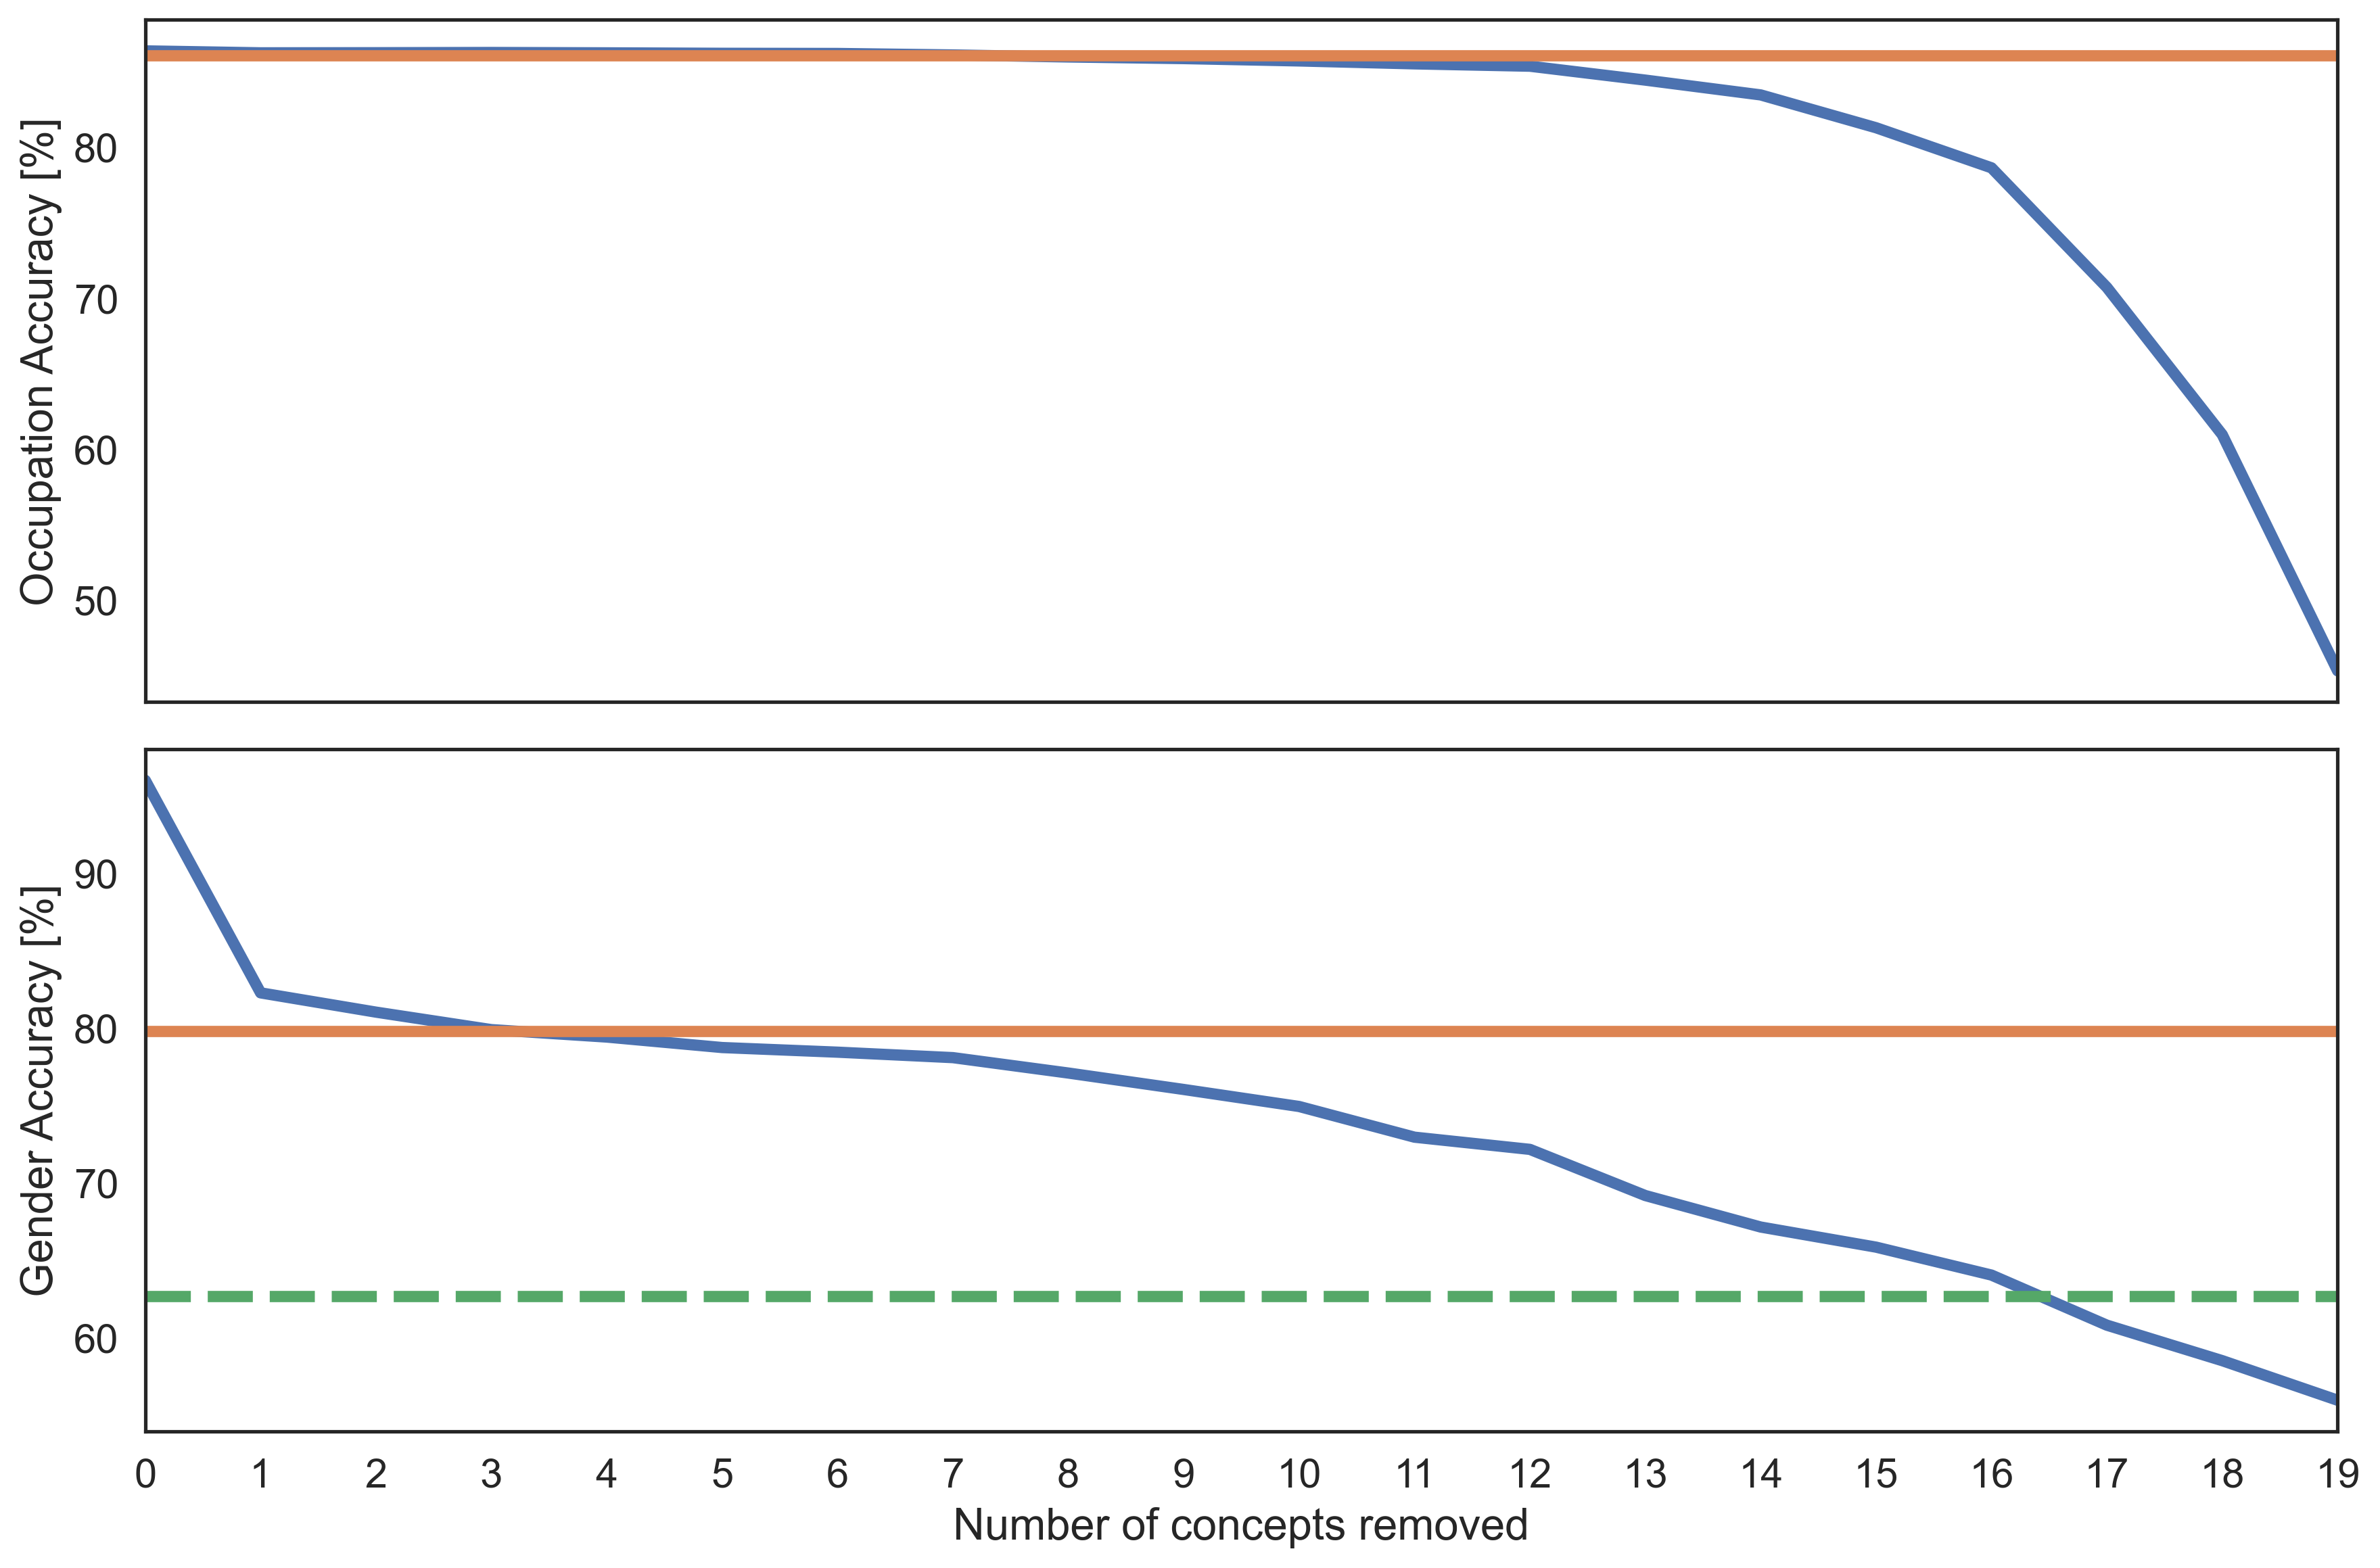

In [5]:
sns.set(font_scale=1.3)
nolegend = True

if nolegend:
  sns.set_style("white")
else:
  sns.set_style("whitegrid")

assert len(acc_gender) == len(concept_removed)
assert len(acc_occ) == len(concept_removed)

acc_gender_baseline2_line = [acc_gender_baseline2] * len(concept_removed)
acc_occ_baseline2_line = [acc_occ_baseline2] * len(concept_removed)
min_gender_line = [min_gender] * len(concept_removed)

c_removed = "Number of concepts removed"
val_acc = "Test Accuracy [%]"
label = "Method"
metric = "Metric"
df = {
    c_removed: [],
    val_acc: [],
    label: [],
    metric: []
}

df[c_removed] += concept_removed
df[val_acc] += acc_gender
df[label] += ['Our method (Bios)'] * len(acc_gender)
df[metric] += ['Gender prediction'] * len(acc_gender)

df[c_removed] += concept_removed
df[val_acc] += acc_occ
df[label] += ['Our method (Bios)'] * len(acc_occ)
df[metric] += ['Occupation prediction'] * len(acc_occ)

df[c_removed] += concept_removed
df[val_acc] += acc_gender_baseline2_line
df[label] += ['Baseline 2 (Bios-Neutral)'] * len(acc_gender_baseline2_line)
df[metric] += ['Gender prediction'] * len(acc_gender_baseline2_line)

df[c_removed] += concept_removed
df[val_acc] += acc_occ_baseline2_line
df[label] += ['Baseline 2 (Bios-Neutral)'] * len(acc_occ_baseline2_line)
df[metric] += ['Occupation prediction'] * len(acc_occ_baseline2_line)

df[c_removed] += concept_removed
df[val_acc] += min_gender_line
df[label] += ['Gender prediction from occupation'] * len(min_gender_line)
df[metric] += ['Gender prediction'] * len(min_gender_line)

df = pd.DataFrame.from_dict(df)
isgenderocc = 'isgenderocc'
df[isgenderocc] = (df[label] == 'Gender prediction from occupation')

fig, axes = plt.subplots(2, 1, figsize=(12, 8), dpi=300, sharex=True)
ax1, ax2 = axes.flatten()

ylb_num = [40, 50, 60, 70, 80, 90, 100]
ylb_num_st = [str(x) for x in ylb_num]

df_top = df[df[metric] == 'Gender prediction']
df_top_name = "Gender Accuracy [%]"
df_top = df_top.rename({val_acc: df_top_name}, axis=1)
df_bottom = df[df[metric] == 'Occupation prediction']
df_bottom_name = "Occupation Accuracy [%]"
df_bottom = df_bottom.rename({val_acc: df_bottom_name}, axis=1)

swap_top_bottom = True
if swap_top_bottom:
  df_top, df_bottom = df_bottom, df_top
  df_top_name, df_bottom_name = df_bottom_name, df_top_name

linewidth = 4.0

sns.lineplot(df_top,
             x=c_removed,
             y=df_top_name,
             hue=label,
             ax=ax1, linewidth=linewidth)
# ax1.set_yticks(ylb_num, ylb_num_st)

sns.lineplot(df_bottom,
             x=c_removed,
             y=df_bottom_name,
             hue=label,
             style=isgenderocc,
             ax=ax2, linewidth=linewidth)
# ax2.set_yticks(ylb_num, ylb_num_st)

handles, labels = ax2.get_legend_handles_labels()
ax2.get_legend().remove()
if not nolegend:
  handles = handles[:-3]
  labels = labels[:-3]
  color = sns.color_palette("deep")[2]
  handles[-1] = plt.Line2D([], [], color=color, linestyle='--', label='Green Line')
  ax1.legend(handles, labels, loc='best')
else:
  ax1.get_legend().remove()


plt.xlim(0, concept_removed[-1])
xlb_num = [i for i in range(20)]
xlb_num_st = [str(x) for x in xlb_num]
plt.xticks(xlb_num, xlb_num_st)
# plt.title(title)

fig.tight_layout()
if nolegend:
  plt.savefig("figures/"+save+'_nolegend.png')
else:
  plt.savefig("figures/"+save+'.png')

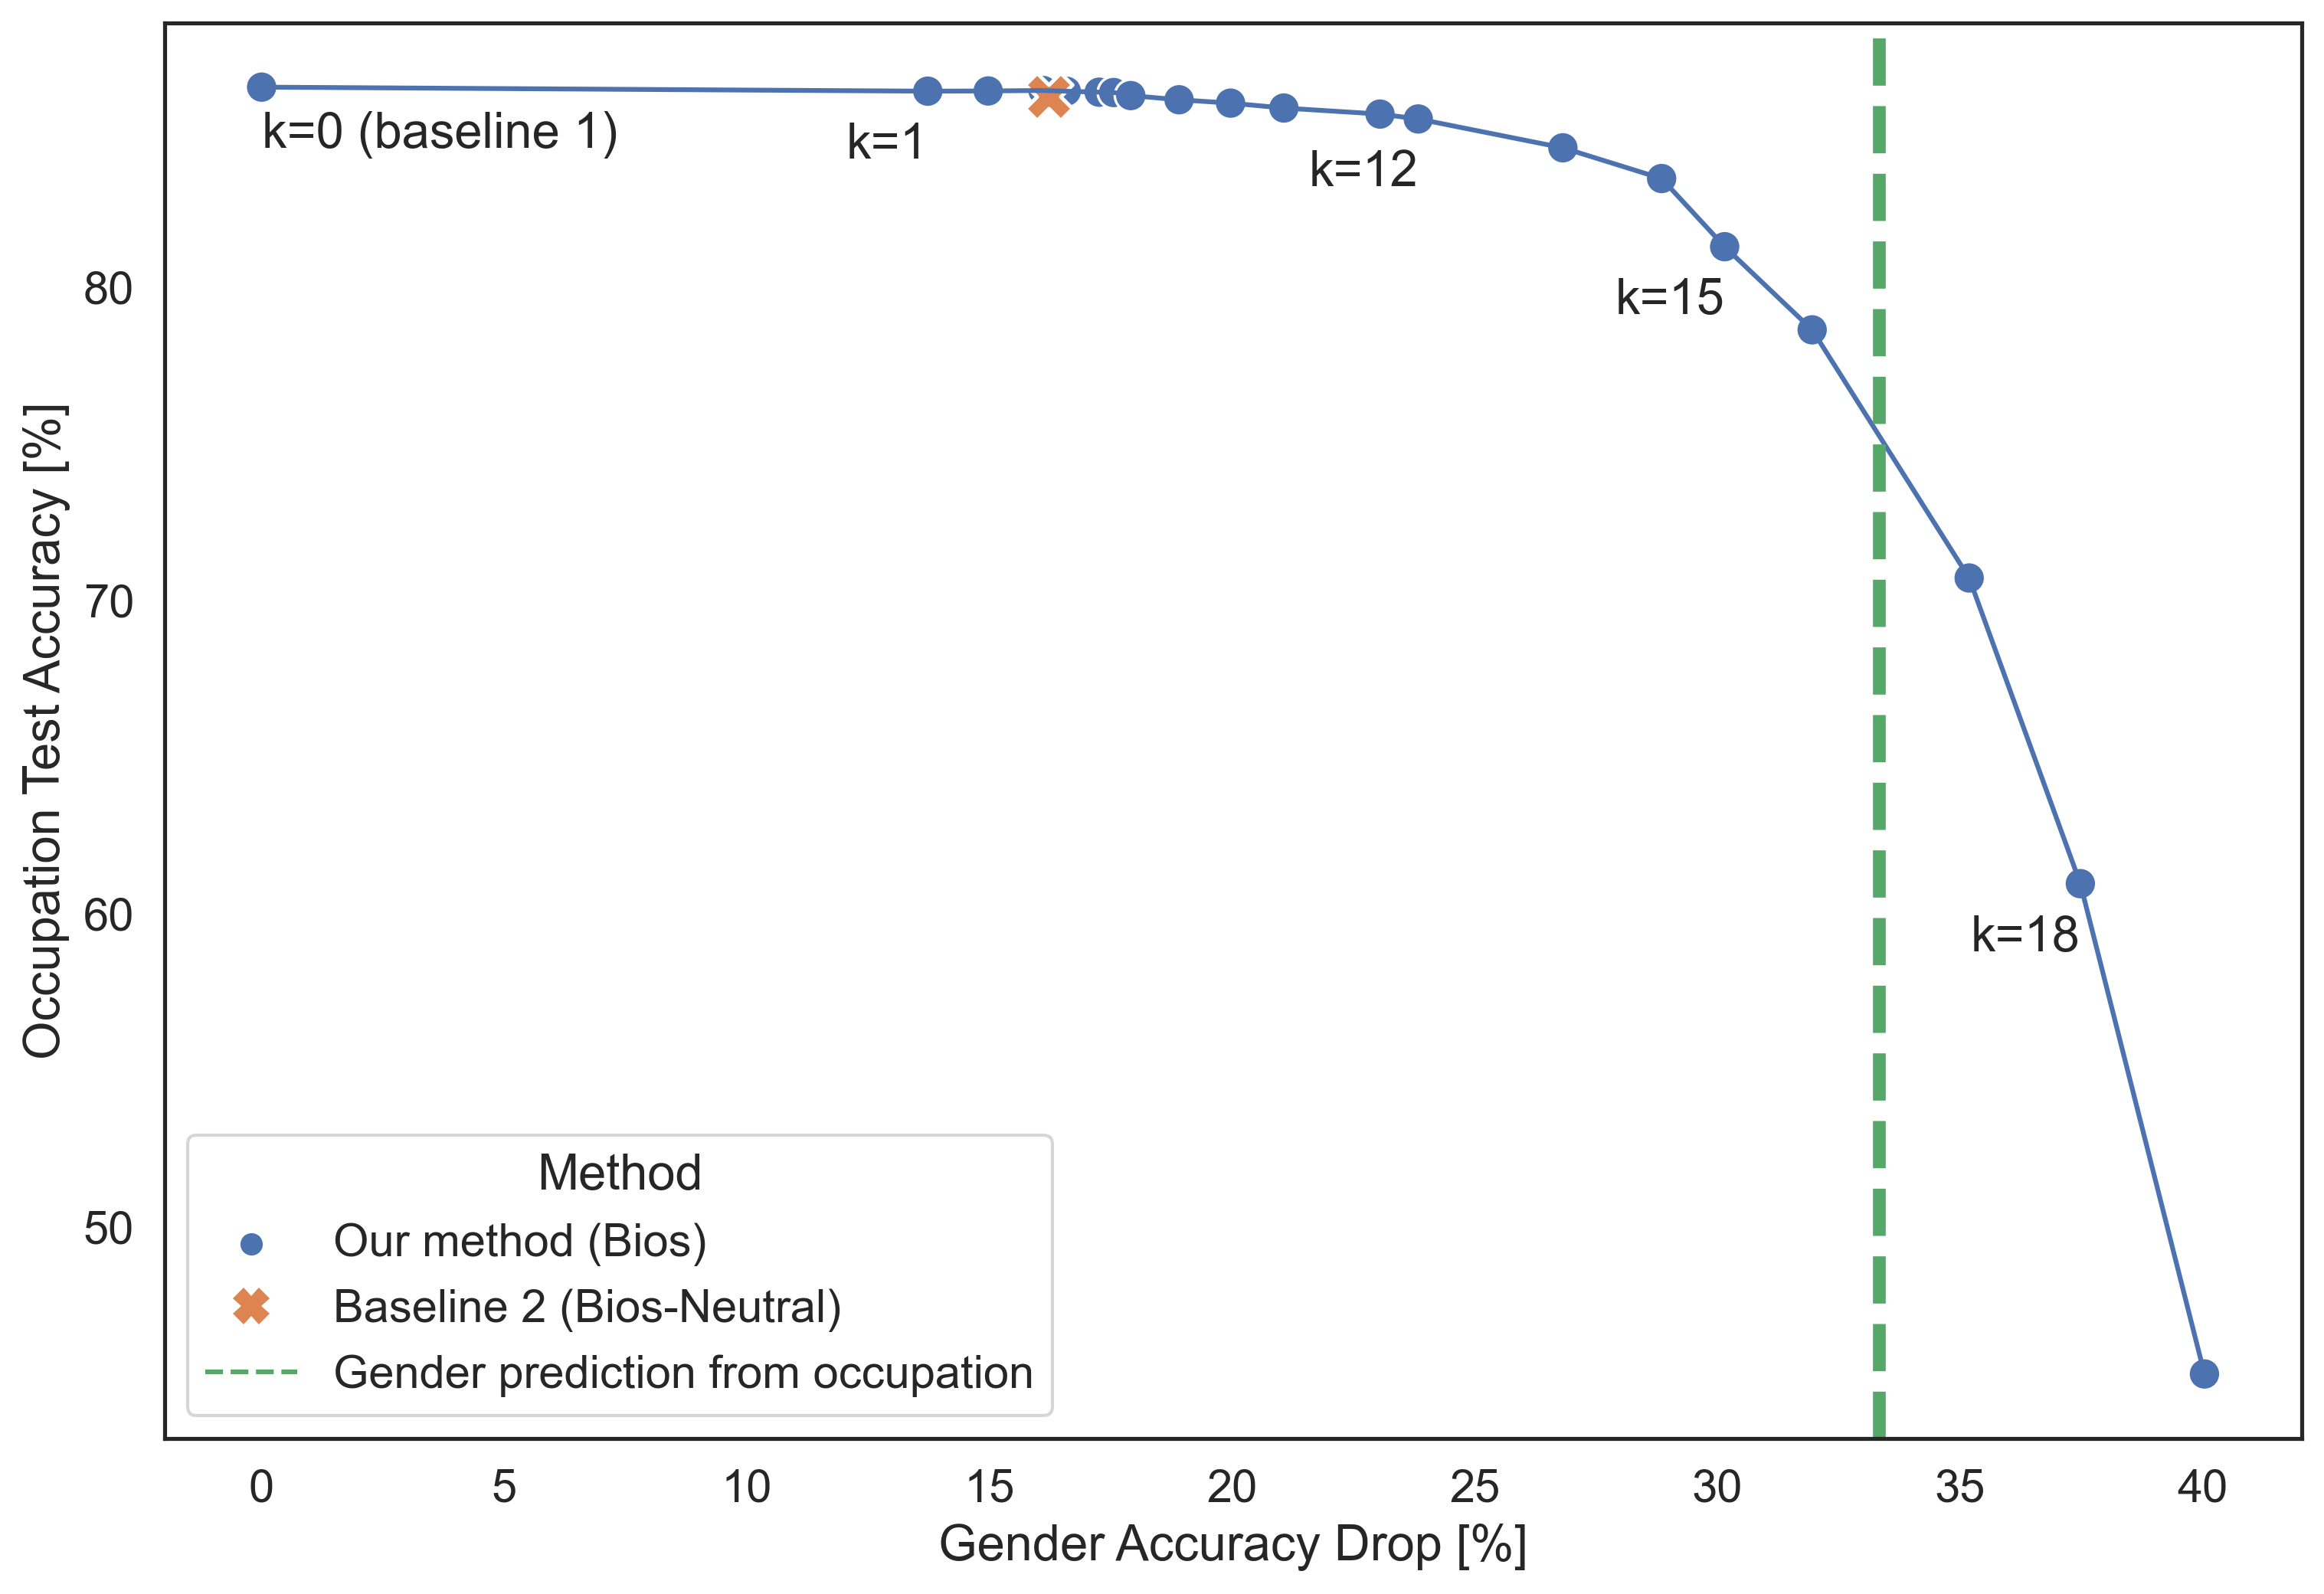

In [6]:
from matplotlib.legend_handler import HandlerBase

sns.set_palette("dark")
sns.set(font_scale=1.3)


nolegend = False
if nolegend:
  sns.set_style("whitegrid")
else:
  sns.set_style("white")


assert len(acc_gender) == len(concept_removed)
assert len(acc_occ) == len(concept_removed)

occ_of_min_gender = acc_occ[0]  # arbitrary, kind-of

drop_occ = False
drop_gender = True
green_line = True
baseline2_star = True

if drop_occ:
  max_occ = acc_occ[0]
  acc_occ = [max_occ - ao for ao in acc_occ]
  occ_of_min_gender = max_occ - occ_of_min_gender
  acc_occ_baseline2 = max_occ - acc_occ_baseline2

if drop_gender:
  max_gender = acc_gender[0]
  acc_gender = [max_gender - ag for ag in acc_gender]
  min_gender = max_gender - min_gender
  acc_gender_baseline2 = max_gender - acc_gender_baseline2

c_removed = "Number of concepts removed"
gen_acc_name = "Gender Accuracy Drop [%]" if drop_gender else "Gender Test Accuracy [%]"
occ_acc_name = "Occupation Accuracy Drop [%]" if drop_occ else "Occupation Test Accuracy [%]"
label = "Model"
df = {
    gen_acc_name: [],
    occ_acc_name: [],
    label: [],
    c_removed: []
}

df[gen_acc_name] += acc_gender
df[occ_acc_name] += acc_occ
df[label] += ['Our method (Bios)'] * len(acc_gender)
df[c_removed] += concept_removed

if not baseline2_star:
  df[gen_acc_name] += [acc_gender_baseline2]
  df[occ_acc_name] += [acc_occ_baseline2]
  df[label] += ['Baseline 2 (Bios-Neutral)']
  df[c_removed] += [0]

if not green_line:
  df[gen_acc_name] += [min_gender]
  df[occ_acc_name] += [occ_of_min_gender]
  df[label] +=['Gender prediction from occupation']
  df[c_removed] += [0]

df = pd.DataFrame.from_dict(df)


plt.figure(figsize=(12, 8), dpi=300)

ax = sns.lineplot(df,
             x=gen_acc_name,
             y=occ_acc_name,
             hue=label,
             markersize=10,
            legend=None)
sns.scatterplot(df,
             x=gen_acc_name,
             y=occ_acc_name,
             hue=label,
             s=100,
             ax=ax)

existing_handles, existing_labels = ax.get_legend_handles_labels()

if baseline2_star:
  color = sns.color_palette("deep")[1]
  sns.scatterplot(x=[acc_gender_baseline2], y=[acc_occ_baseline2], s=220, marker='X', c=[color])
  existing_handles.append(plt.Line2D([0], [0], marker='X', markersize=10, color=color, linestyle='None'))
  existing_labels.append('Baseline 2 (Bios-Neutral)')

if green_line:
  color = sns.color_palette("deep")[2]
  plt.axvline(x=min_gender, ymin=0, ymax=1, color=color, linestyle='--', linewidth=4.0)
  existing_handles.append(plt.Line2D([], [], color=color, linestyle='--', label='Green Line'))
  existing_labels.append('Gender prediction from occupation')



x_offset = 1 if not drop_gender else -1
pos_ha = 'left' if not drop_gender else 'right'
pos_va = 'top' if not drop_occ else 'bottom'
keep = [0, 1, 12, 15, 18]
for i in range(len(concept_removed)):
  if i not in keep:
    continue
  row = df.iloc[i]
  if i == 0:
    text = 'k=0 (baseline 1)'
    x = row[gen_acc_name]
    y = row[occ_acc_name] - 0.75
    ax.text(x, y, text, ha='left', va=pos_va)
  else:
    text = 'k=' + str(row[c_removed])
    x = row[gen_acc_name]
    y = row[occ_acc_name] + x_offset
    ax.text(x, y, text, ha=pos_ha, va=pos_va)

# plt.title(title)
ax.legend(existing_handles, existing_labels, title='Method', loc='best')
if nolegend:
  ax.get_legend().remove()

plt.savefig("figures/"+save+f"{drop_gender}_{drop_occ}_legend{nolegend}"+'.png')

# Explanations

In [30]:
import pickle
import numpy as np

global_importance_gender = pickle.load(open(f'global_importance/gi_gender_{method_name}{num_components}_{model_type}_baseline_{baseline}.pkl',"rb"))
global_importance_occ = pickle.load(open(f'global_importance/gi_occupation_{method_name}{num_components}_{model_type}_baseline_{baseline}.pkl',"rb"))


In [31]:
angle = np.arctan(global_importance_occ / global_importance_gender) * 180 / np.pi

sentences_train = []

for k in range(len(dt_X_train)):
    sentences_train.append(dt_X_train[k][0])

gender_pred_train = torch.argmax(pg_model(train_features), -1)
label_pred_train = torch.argmax(model.end_model(train_features), -1)

sentences_train = np.array(sentences_train)
train_labels = np.array(train_labels)
label_pred_train = np.array(label_pred_train)
gender_train = np.array(gender_train)
gender_pred_train = np.array(gender_pred_train)


names_g = ['F', 'M']
names_occ = ['surgeon', 'pastor', 'photographer', 'professor', 'chiropractor', 'software_engineer', 'teacher', 'poet', 'dj', 'rapper', 'paralegal', 'physician', 
              'journalist', 'architect', 'attorney', 'yoga_teacher', 'nurse', 'painter', 'model', 'composer', 'personal_trainer','filmmaker', 'comedian', 'accountant', 
              'interior_designer', 'dentist', 'psychologist', 'dietitian']


In [32]:
n = 5 #number of bios for each concepts

l_concept_id = [15, 18, 19]
#nb_con = 20 #number of concepts
# lookat = "angle"  #"gender" or "occupation" or "angle"

# if lookat == "gender":
#   l_concept_id = np.argsort(global_importance_gender)[::-1][:nb_con]
# elif lookat == "occupation":
#   l_concept_id = np.argsort(global_importance_occ)[::-1][:nb_con]
# else:
#    l_concept_id = np.argsort(angle)[:nb_con]
  

l_mip_ids, l_mip_sentences, l_mip_label, l_mip_predict_label, l_mip_gender, l_mip_predict_gender = [], [], [], [], [], []

for concept_id in l_concept_id:
    mip_ids = np.argsort(U_train[:, concept_id].numpy())[::-1][:n]
    l_mip_ids.extend(mip_ids)
    l_mip_sentences.extend(sentences_train[mip_ids])
    l_mip_label.extend(train_labels[mip_ids])
    l_mip_predict_label.extend(label_pred_train[mip_ids])
    l_mip_gender.extend(gender_train[mip_ids])
    l_mip_predict_gender.extend(gender_pred_train[mip_ids])

In [33]:
# from explaination import occlusion_concepts, viz_concepts, print_legend

# l_ignore_words = ["’", "'", ",", ".", "...", "..", "....", ":", "!", "?", "", " ", "(", ")"]

# l_concept_id = [15, 18, 19]

# print("importance gender / importance occupation")
# colors = print_legend(l_concept_id, global_importance_gender, global_importance_occ)

# i = 0
# for sentence in l_mip_sentences:
#   if i%n == 0:
#     print("\n")
#     print(str(n) + " most important bios - concept" + str(i//n + 1) +":")
#     print("\n")
#   print('sentence:', l_mip_ids[i])
#   print('occupation: true label:', names_occ[int(l_mip_label[i])], '; predicted label:', names_occ[int(l_mip_predict_label[i])])
#   print('gender: true label:', names_g[l_mip_gender[i]], '; predicted label:', names_g[l_mip_predict_gender[i]])

#   phi = occlusion_concepts(sentence, model, tokenizer, W, l_concept_id, ignore_words = [], device = device)
  
#   phi /= np.max(np.abs(phi)) + 1e-5
#   viz_concepts(sentence, phi, colors, ignore_words = [])
#   i += 1

In [37]:
l_mip_sentences_chosen = [230484, 7029, 155554, 94984, 82706, 254362, 205272, 226245, 81814, 227333, 90373, 82798, 143102, 261617, 
                          219844, 125561, 39863, 246224, 265371, 155464, 123403, 229367]


l_mip_sentences = sentences_train[l_mip_sentences_chosen]
l_mip_label = train_labels[l_mip_sentences_chosen]
l_mip_predict_label = label_pred_train[l_mip_sentences_chosen]
l_mip_gender = gender_train[l_mip_sentences_chosen]
l_mip_predict_gender = gender_pred_train[l_mip_sentences_chosen]

from explaination import occlusion_concepts, viz_concepts, print_legend, print_legend2

l_ignore_words = ["’", "'", ",", ".", "...", "..", "....", ":", "!", "?", "", " ", "(", ")"]

l_concept_id = [15, 18, 19]
conceptnames = [1, 8, 19]


print("gender importance / occupation importance")


colors = { 
    0: "rgba(255, 102, 122, ",
    1: "rgba(179, 174, 54, ", 
    2: "rgba(45, 136, 179, ",
}
print_legend2(colors, l_concept_id, global_importance_gender, global_importance_occ, conceptnames)
#colors = print_legend(l_concept_id, global_importance_gender, global_importance_occ, conceptnames)

i = 0
for sentence in l_mip_sentences:
  print('sentence:', l_mip_sentences_chosen[i])
  print('occupation: true label:', names_occ[int(l_mip_label[i])], '; predicted label:', names_occ[int(l_mip_predict_label[i])])
  print('gender: true label:', names_g[l_mip_gender[i]], '; predicted label:', names_g[l_mip_predict_gender[i]])

  phi = occlusion_concepts(sentence, model, tokenizer, W, l_concept_id, ignore_words = [], device = device)
  
  phi /= np.max(np.abs(phi)) + 1e-5
  viz_concepts(sentence, phi, colors, ignore_words = [])
  i += 1

gender importance / occupation importance


sentence: 230484
occupation: true label: professor ; predicted label: dietitian
gender: true label: F ; predicted label: F


sentence: 7029
occupation: true label: dietitian ; predicted label: dietitian
gender: true label: F ; predicted label: F


sentence: 155554
occupation: true label: personal_trainer ; predicted label: dietitian
gender: true label: F ; predicted label: F


sentence: 94984
occupation: true label: personal_trainer ; predicted label: model
gender: true label: F ; predicted label: F


sentence: 82706
occupation: true label: chiropractor ; predicted label: chiropractor
gender: true label: M ; predicted label: M


sentence: 254362
occupation: true label: chiropractor ; predicted label: chiropractor
gender: true label: F ; predicted label: F


sentence: 205272
occupation: true label: dietitian ; predicted label: dietitian
gender: true label: F ; predicted label: F


sentence: 226245
occupation: true label: software_engineer ; predicted label: software_engineer
gender: true label: M ; predicted label: M


sentence: 81814
occupation: true label: software_engineer ; predicted label: software_engineer
gender: true label: M ; predicted label: M


sentence: 227333
occupation: true label: model ; predicted label: model
gender: true label: F ; predicted label: F


sentence: 90373
occupation: true label: model ; predicted label: model
gender: true label: F ; predicted label: F


sentence: 82798
occupation: true label: psychologist ; predicted label: nurse
gender: true label: F ; predicted label: F


sentence: 143102
occupation: true label: professor ; predicted label: professor
gender: true label: F ; predicted label: F


sentence: 261617
occupation: true label: professor ; predicted label: professor
gender: true label: F ; predicted label: F


sentence: 219844
occupation: true label: professor ; predicted label: professor
gender: true label: F ; predicted label: F


sentence: 125561
occupation: true label: professor ; predicted label: professor
gender: true label: F ; predicted label: M


sentence: 39863
occupation: true label: architect ; predicted label: professor
gender: true label: M ; predicted label: M


sentence: 246224
occupation: true label: professor ; predicted label: professor
gender: true label: F ; predicted label: F


sentence: 265371
occupation: true label: architect ; predicted label: software_engineer
gender: true label: M ; predicted label: M


sentence: 155464
occupation: true label: professor ; predicted label: professor
gender: true label: F ; predicted label: F


sentence: 123403
occupation: true label: professor ; predicted label: professor
gender: true label: F ; predicted label: M


sentence: 229367
occupation: true label: professor ; predicted label: professor
gender: true label: M ; predicted label: M
